<a href="https://colab.research.google.com/github/BachiLi/A-Tour-of-Computer-Animation/blob/main/A_Tour_of_Computer_Animation_4_Elastic_Simulation_and_Mass_Spring_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Last time we use an 1D example $\ddot{x} = -x$ (called [Hooke's law](https://en.wikipedia.org/wiki/Hooke%27s_law)) to demonstrate the behaviors of time integrators. Hooke's law turns out to be an extremely versatile model and can be used for modelling a very wide range of physics phenomonon.

In this chapter, we will generalize Hooke's law to 2D and higher-dimensional space with multiple nodes, and use it to simulate elastic objects and generate fun animations. 

Let's observe the kinetic and potential energy of the 1D model first: the kinetic energy is $\frac{1}{2} m \dot{x}^2$ and the potential energy is $\frac{1}{2} x^2$. 

Let's make it slightly more general: we first introduce a *spring constant* $k$ to model how "bouncy" the mass spring is. Next, we attach two masses $m_0$ and $m_1$ at both sides of the spring, and give the mass spring a "rest length" $l_r$. 

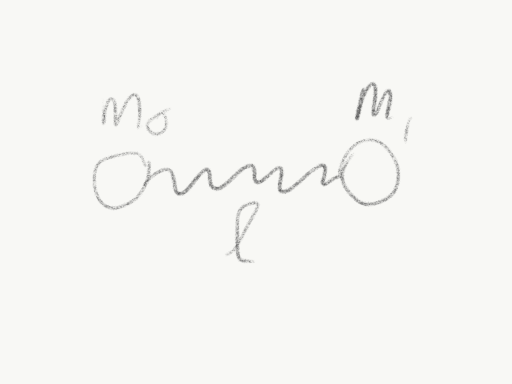

The kinetic energy of the two masses $x_0$ and $x_1$ is:

$$K = \frac{1}{2} m_0 \dot{x}_0^2 + \frac{1}{2} m_1 \dot{x}_1^2$$

and the potential energy is:

$$U = \frac{1}{2} k \left( \left\| x_0 - x_1 \right\| - l_r \right)^2$$

The Euler-Lagrange equation for the Lagrangian $L = K - U$ is thus

$$
\begin{split}
\frac{\partial L}{\partial x_0} &= -k \left(\left\| x_0 - x_1 \right\| - l_r\right) \frac{x_0 - x_1}{\left\| x_0 - x_1 \right\|} \\
\frac{\partial L}{\partial x_1} &= -k \left(\left\| x_0 - x_1 \right\| - l_r\right) \frac{x_1 - x_0}{\left\| x_0 - x_1 \right\|} \\
\frac{d}{dt}\frac{\partial L}{\partial \dot{x}_0} &= m_0 \ddot{x}_0 \\
\frac{d}{dt}\frac{\partial L}{\partial \dot{x}_1} &= m_1 \ddot{x}_1 \\
&\downarrow \\
\ddot{x}_0 &= -\frac{1}{m_0} k \left(\left\| x_0 - x_1 \right\| - l_r\right) \frac{x_0 - x_1}{\left\| x_0 - x_1 \right\|} \\
\ddot{x}_1 &= -\frac{1}{m_1} k \left(\left\| x_0 - x_1 \right\| - l_r\right) \frac{x_1 - x_0}{\left\| x_0 - x_1 \right\|}
\end{split}
$$

Note that, somewhat annoyingly, the ODE becomes non-linear because of the distance between $x_0$ and $x_1$. I don't know if there is a closed-form of this ODE system (probably not). We can use a leapfrog integrator to visualize it:

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from functools import partial
import numpy as np
# This time the computation will be more involved, so we will use Numba to speed it up.
# see https://numba.pydata.org/ for more information
from numba import jit

fps = 20

m0 = 1
m1 = 1
x_init = np.array([[1.0, -1.0], [0.0,  0.0]])
v_init = np.array([[0.0,  0.0], [0.5, -0.5]])

@jit(nopython=True)
def two_mass_spring_leapfrog(k, lr, time_step, t, x, v):
    ct = 0
    while True:
        x0 = x[:, 0]
        x1 = x[:, 1]
        dist = np.linalg.norm(x0 - x1)
        nv_half = v + 0.5 * time_step * np.stack((\
            -(1 / m0) * k * (dist - lr) * (x0 - x1) / dist,
            -(1 / m1) * k * (dist - lr) * (x1 - x0) / dist), axis = -1)
        nx = x + time_step * nv_half
        nx0 = nx[:, 0]
        nx1 = nx[:, 1]
        nv = nv_half + 0.5 * time_step * np.stack((\
            -(1 / m0) * k * (dist - lr) * (nx0 - nx1) / dist,
            -(1 / m1) * k * (dist - lr) * (nx1 - nx0) / dist), axis = -1)
        x = nx
        v = nv
        ct += time_step
        if ct >= t:
            break
    return ct, x, v

def visualize(ode_solver):
    fig = plt.figure()
    ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
    line, = ax.plot([], [], '-', lw=2)
    point, = ax.plot([], [], 'g.', ms=20)
    plt.axis('off')

    t = 0
    x = x_init
    v = v_init
    def animate(i):
        nonlocal t, x, v
        dt, x, v = ode_solver(1.0/fps, x, v)
        t += dt
        line.set_data(x[0, :], x[1, :])
        point.set_data(x[0, :], x[1, :])
        return point,

    plt.close()
    return animation.FuncAnimation(fig, animate, frames=500, interval=fps, blit=True)

# k = 1, lr = 1.5, time_step = 0.01
anim1 = visualize(partial(two_mass_spring_leapfrog, 1, 1.5, 0.01))
HTML(anim1.to_html5_video())

We can play with a different spring constant e.g., k = 8, to make the spring a bit more "bouncy":

In [ ]:
# k = 8, lr = 1.5, time step = 0.001
anim2 = visualize(partial(two_mass_spring_leapfrog, 8, 1.5, 0.001))
HTML(anim2.to_html5_video())

By the way, what would happen if we use a large time step?

In [ ]:
anim3 = visualize(partial(two_mass_spring_leapfrog, 8, 1.5, 0.05))
HTML(anim3.to_html5_video())

You can see that the animation "explodes". This is why having a stable time integrator is important. We'll show how to efficiently implement an implicit time integrator for mass spring systems later.

The model above shows how we can model deformable objects: we can construct a graph, where masses (nodes) are connected by springs (edges). (TODO: illustration)

For each node $x_i$, we have the following ODE:

$$\ddot{x}_i = -\frac{1}{m_i} \sum_{j \in N_i} k_{ij} \left(\left\| x_i - x_j \right\| - l_r^{ij}\right) \frac{x_i - x_j}{\left\| x_i - x_j \right\|}$$

where $N_i$ is the set of the neighbors of node $i$, $k_{ij}$ and $l_r^{ij}$ are the spring coefficient and rest length associated with the edge $ij$ respectively. Let's try this with a grid structure graph with code!

In [ ]:
x_init = np.stack(np.meshgrid(np.linspace(-1, 1, 5), np.linspace(-1, 1, 5)))
v_init = np.zeros_like(x_init)

# The code here is not the most idiomatic numpy code, but I optimize for
# pedagogical clearity.
@jit(nopython=True)
def grid_mass_spring_leapfrog(k, lr, time_step, t, x, v):
    ct = 0
    while True:
        # Some utility functions
        def mass_spring_force(lr, xi, xj):
            dist = np.linalg.norm(xi - xj)
            return -k * (dist - lr) * (xi - xj) / dist

        # An unfortunate naming clash: i & j variables here do not correspond to 
        # i & j in x_i and x_j in the equation. They are the 2D coordinates of the grid. 
        def accumulate_spring_forces_from_eight_neighbors(x, i, j):
            F = np.zeros(2)
            xi = x[:, i, j]
            if i > 0:
                F += mass_spring_force(lr, xi, x[:, i-1, j])
            if i < x.shape[1] - 1:
                F += mass_spring_force(lr, xi, x[:, i+1, j])
            if j > 0:
                F += mass_spring_force(lr, xi, x[:, i, j-1])
            if j < x.shape[2] - 1:
                F += mass_spring_force(lr, xi, x[:, i, j+1])
            # For the diagonals, the rest length should be sqrt(2) longer
            lr_diag = math.sqrt(2) * lr
            if i > 0 and j > 0:
                F += mass_spring_force(lr_diag, xi, x[:, i-1, j-1])
            if i < x.shape[1] - 1 and j > 0:
                F += mass_spring_force(lr_diag, xi, x[:, i+1, j-1])
            if i > 0 and j < x.shape[2] - 1:
                F += mass_spring_force(lr_diag, xi, x[:, i-1, j+1])
            if i < x.shape[1] - 1 and j < x.shape[2] - 1:
                F += mass_spring_force(lr_diag, xi, x[:, i+1, j+1])
            return F

        def compute_force(x):
            F = np.zeros_like(x)
            for i in range(x.shape[1]):
                for j in range(x.shape[2]):
                    F[:, i, j] = accumulate_spring_forces_from_eight_neighbors(x, i, j)
            return F

        nv_half = v + 0.5 * time_step * compute_force(x)
        nx = x + time_step * nv_half
        nv = nv_half + 0.5 * time_step * compute_force(nx)

        x = nx
        v = nv
        ct += time_step
        if ct >= t:
            break
    return ct, x, v

def visualize(ode_solver, xlim, ylim):
    fig = plt.figure()
    ax = plt.axes(xlim=xlim, ylim=ylim)
    line, = ax.plot([], [], '-', lw=2)
    point, = ax.plot([], [], 'g.', ms=20)
    plt.axis('off')

    t = 0
    x = x_init
    v = v_init
    def animate(i):
        nonlocal t, x, v
        dt, x, v = ode_solver(1.0/fps, x, v)
        t += dt
        
        # Plot the fancy lines! Use nan to break the lines.
        lx_horiz = np.stack([np.concatenate([x[0, i, :], np.array([np.nan])]) for i in range(x.shape[1])])
        ly_horiz = np.stack([np.concatenate([x[1, i, :], np.array([np.nan])]) for i in range(x.shape[1])])
        lx_verti = np.stack([np.concatenate([x[0, :, i], np.array([np.nan])]) for i in range(x.shape[2])])
        ly_verti = np.stack([np.concatenate([x[1, :, i], np.array([np.nan])]) for i in range(x.shape[2])])
        lx_diag = []
        ly_diag = []
        for i in range(x.shape[1]-1):
            for j in range(x.shape[2]-1):
                lx_diag += [x[0, i, j], x[0, i+1, j+1], np.nan]
                ly_diag += [x[1, i, j], x[1, i+1, j+1], np.nan]
        for i in range(x.shape[1]-1):
            for j in range(1,x.shape[2]):
                lx_diag += [x[0, i, j], x[0, i+1, j-1], np.nan]
                ly_diag += [x[1, i, j], x[1, i+1, j-1], np.nan]
        lx_diag = np.array(lx_diag)
        ly_diag = np.array(ly_diag)
        lx = np.concatenate([lx_horiz.reshape(-1), lx_verti.reshape(-1), lx_diag])
        ly = np.concatenate([ly_horiz.reshape(-1), ly_verti.reshape(-1), ly_diag])
        line.set_data(lx, ly)
        point.set_data(x[0, :, :], x[1, :, :])
        return point,

    plt.close()
    return animation.FuncAnimation(fig, animate, frames=500, interval=fps, blit=True)

# k = 1, lr = 0.45
anim = visualize(partial(grid_mass_spring_leapfrog, 1, 0.45, 0.01), xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
HTML(anim.to_html5_video())

Just to have some more fun, let's add gravity and collision with the floor. Implementing efficient and correct collision is tricky (we need to apply an impulse force whenever one of the nodes hit the floor, this requires us to take very small time steps when the object is near the floor). We will use an incorrect but simple method called the penalty method: whenever a node penetrates the floor, we apply a strong upward force $F_c = k_c d$ to the nodes where $k_c$ is a large constant and $d$ is the distance of the object to the floor. Finally, to make it look more realistic, we apply a "damping" factor to make the energy dissapate over time, so that the object does not keep wobbling.

In [ ]:
x_init = np.stack(np.meshgrid(np.linspace(-1, 1, 5), np.linspace(-1, 1, 5)))
# apply a rotation to the initial state just for fun
rot = np.array([[np.cos(math.pi / 3), -np.sin(math.pi / 3)], [np.sin(math.pi / 3), np.cos(math.pi / 3)]]).reshape(2, 2)
for i in range(x_init.shape[1]):
    for j in range(x_init.shape[2]):
        x_init[:, i, j] = rot @ x_init[:, i, j]
v_init = np.zeros_like(x_init)
g = 2.0
kc = 1000
floor = -2.0

@jit(nopython=True)
def grid_mass_spring_gravity_collision_leapfrog(k, lr, damping, time_step, t, x, v):
    ct = 0
    while True:
        def mass_spring_force(lr, xi, xj):
            dist = np.linalg.norm(xi - xj)
            return -k * (dist - lr) * (xi - xj) / dist

        def accumulate_spring_forces_from_eight_neighbors(x, i, j):
            F = np.zeros(2)
            xi = x[:, i, j]
            if i > 0:
                F += mass_spring_force(lr, xi, x[:, i-1, j])
            if i < x.shape[1] - 1:
                F += mass_spring_force(lr, xi, x[:, i+1, j])
            if j > 0:
                F += mass_spring_force(lr, xi, x[:, i, j-1])
            if j < x.shape[2] - 1:
                F += mass_spring_force(lr, xi, x[:, i, j+1])
            # For the diagonals, the rest length should be sqrt(2) longer
            lr_diag = math.sqrt(2) * lr
            if i > 0 and j > 0:
                F += mass_spring_force(lr_diag, xi, x[:, i-1, j-1])
            if i < x.shape[1] - 1 and j > 0:
                F += mass_spring_force(lr_diag, xi, x[:, i+1, j-1])
            if i > 0 and j < x.shape[2] - 1:
                F += mass_spring_force(lr_diag, xi, x[:, i-1, j+1])
            if i < x.shape[1] - 1 and j < x.shape[2] - 1:
                F += mass_spring_force(lr_diag, xi, x[:, i+1, j+1])
            return F

        def compute_force(x, v):
            # spring force
            F = np.zeros_like(v)
            for i in range(x.shape[1]):
                for j in range(x.shape[2]):
                    F[:, i, j] = accumulate_spring_forces_from_eight_neighbors(x, i, j)
            # gravity
            F[1,:,:] -= g
            # penalty
            F[1,:,:] += kc * np.maximum(-(x[1,:,:] - floor), np.zeros_like(x[1,:,:]))
            # damping
            F -= damping * v
            return F

        nv_half = v + 0.5 * time_step * compute_force(x, v)
        nx = x + time_step * nv_half
        nv = nv_half + 0.5 * time_step * compute_force(nx, nv_half)

        x = nx
        v = nv
        ct += time_step
        if ct >= t:
            break
    return ct, x, v

# k = 200, lr = 0.5, damping = 0.2, time step = 0.005
anim = visualize(partial(grid_mass_spring_gravity_collision_leapfrog, 200, 0.5, 0.2, 0.005), xlim=(-2, 2), ylim=(-2, 2))
HTML(anim.to_html5_video())

Even with some damping, you can still see that the object "wobbles" a bit, making the animation look less realistic. Again, if we set a large step size, the animation will explode.

In [ ]:
# k = 200, lr = 0.5, damping = 0.2, time step = 0.05
anim = visualize(partial(grid_mass_spring_gravity_collision_leapfrog, 200, 0.5, 0.2, 0.05), xlim=(-2, 2), ylim=(-2, 2))
HTML(anim.to_html5_video())

How do we avoid these "explosions"? As we've learned in the previous chapter, we can use implicit integrators to make the simulation a lot more stable. Given the following ODE with a conservative force:

$$
\ddot{x}_i = \frac{1}{m_i} \left( -\sum_{j \in N_i} k_{ij} \left(\left\| x_i - x_j \right\| - l_r^{ij}\right) \frac{x_i - x_j}{\left\| x_i - x_j \right\|} + F_{\text{ext}}(x_i) \right) = \frac{1}{m_i} \left( F_{\text{spring}}(x_i) + F_{\text{ext}}(x_i) \right) = \frac{1}{m_i} F(x_i)
$$

where $F_{\text{ext}}$ accounts for external forces like gravity and collision (damping will be discussed later). We will apply an implicit Euler method using the follow update rule:

$$
\begin{split}
v_i^{n+1} &= v_i^n + \Delta_t \frac{1}{m_i} F(x_i^{n+1}) \\
x_i^{n+1} &= x_i^n + \Delta_t v_i^{n+1} 
\end{split}
$$

Note that the second equation implies $x_i^n = x_i^{n-1} + \Delta_t v_i^n$. Therefore by substituting $v_i^{n+1}$ using the first equation, and substituting $v_i^n = \frac{x_i^n - x_i^{n-1}}{\Delta_t}$, we get:

$$
\begin{split}
x_i^{n+1} - 2x_i^{n} + x_i^{n-1} &= \Delta_t^2 \frac{1}{m_i} F(x_i^{n+1}) \\
&= \Delta_t^2 \frac{-1}{m_i} \left( \sum_{j \in N_i} k_{ij} \left(\left\| x_i^{n+1} - x_j^{n+1} \right\| - l_r^{ij}\right) \frac{x_i^{n+1} - x_j^{n+1}}{\left\| x_i^{n+1} - x_j^{n+1} \right\|} - F_{\text{ext}}(x_i^{n+1}) \right)
\end{split}
$$

Interestingly, this update rule completely removes the need of maintaining velocity in our code (but now you need to maintain two sets of $x$). As such, methods that are based on this update rule are often called [**position-based dynamics**](http://mmacklin.com/flex_eurographics_tutorial.pdf). We will dive a bit deeper into this in the next chapter.

So, now our task is, given $x^n$ and $x^{n-1}$, solve $x^{n+1}$ such that the equation above is satisfied. This is a non-linear system, thus we need to solve its roots with an iterative solver. We rearrange the terms so that everything is on the same side:

$$
x_i^{n+1} + \Delta_t^2 \frac{1}{m_i} \left( \sum_{j \in N_i} k_{ij} \left(\left\| x_i^{n+1} - x_j^{n+1} \right\| - l_r^{ij}\right) \frac{x_i^{n+1} - x_j^{n+1}}{\left\| x_i^{n+1} - x_j^{n+1} \right\|} - F_{\text{ext}}(x_i^{n+1}) \right) - 2x_i^{n} + x_i^{n-1} = G_i(x_i^{n+1}) = 0
$$

We want to solve for $x^{n+1}$ such that $G(x_i^{n+1}) = 0$ for all $i$ ($G_i$ is a function that maps $\mathbb{R}^2 \rightarrow \mathbb{R}^2$). We will further collect all of the $G_i$ functions and form the equation $G(x^{n+1}) = 0$ ($G$ maps $\mathbb{R}^{2 N} \rightarrow \mathbb{R}^{2 N}$, where $N$ is the number of nodes). Usually a root finding method, such as the [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), will be used for solving the root.


An alternative way to look at this problem is to notice that $x^{n+1}$ is the minimum of an objective function, given $x_i^n$ and $x_i^{n-1}$:

$$
x_i^{n+1} = \underset{x}{\operatorname{\arg\min}} \sum_i \frac{1}{2} \frac{1}{\Delta_t^2} m_i \left(x_i - 2 x_i^{n} + x_i^{n-1}\right)^2 + E(x_i) = \underset{x}{\operatorname{\arg\min}} \sum_i \frac{1}{2} \frac{1}{\Delta_t^2} m_i \left(x_i - (x_i^{n} + \Delta_t v_i^{n})\right)^2 + E(x_i)
$$

where $E$ is the potential energy and $\nabla_x E(x) = F(x)$. The first term is trying to match the position to the explicit update $x^n_i + \Delta_t v^{n}_i$, and the second term is trying to minimize the potential energy (because they will be transformed into kinetic energy). If we take a really large time step, the potential energy term dominates and it will be minimized -- making the motion stable as it minimizes the forces. This view enables us to solve for the motion using various optimization algorithms. 


We will use Newton method to iteratively update the solution. We start from some initial guess $q_0 = x^{n}$. Let $J$ be the Jacobian matrix of $G$ ($J$ has size $2N \times 2N$), we update our solution using the following:

$$
q^{t+1} = q^{t} - J^{-1}(q^t) G(q^t)
$$

Notice that $J$ is a sparse matrix: each node $x_i$ is only related to its neighbor. We have:

$$
\frac{\partial G_i}{\partial x_i} = 1 + \frac{\Delta_t^2}{m_i} \left( \sum_{j \in N_i} k_{ij} \left( 1 - \frac{l_r^{ij}}{\left\| x_i - x_j \right\|} + \frac{l_r^{ij} \left( x_i - x_j \right) \circ \left( x_i - x_j \right) }{\left\| x_i - x_j \right\|^3}\right) - \frac{\partial F_{\text{ext}}(x_i)}{\partial x_i} \right)
$$

and

$$
\frac{\partial G_i}{\partial x_j} = 
\frac{\Delta_t^2}{m_i} k_{ij} \left(-1 + \frac{l_r^{ij}}{\left\| x_i - x_j \right\|} - \frac{l_r^{ij} \left( x_i - x_j \right) \circ \left( x_i - x_j \right) }{\left\| x_i - x_j \right\|^3} \right)
$$

where $\circ$ represents element-wise multiplications (You can use an automatic differentiation software to derive this for you. [CasADi](https://web.casadi.org/) is pretty good).

How do we invert the $J$ matrix? Normally, if $J$ is a dense matrix, [Gauss elimination](https://en.wikipedia.org/wiki/Gaussian_elimination) is the way to go. However Gauss elimination is slow when there are many nodes. Solving this linear system $J(q^t)^{-1} G(q^t)$ correctly and efficiently is an art in itself (and generated many research papers).

Since $J$ is sparse, we can actually solve it using iterative methods (so we are applying an iterative method inside the Newton method iteration!). A commonly used technique for the inversion used in computer animation is the [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method). I'll copy paste the algorithm from Wikipedia here. Interested readers should consult the derivation from the super well-written text ["An Introduction to Conjugate Gradient without the Agonizing Pain"](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf).


Many sparse linear system solvers require the linear system to be symmetric and positive definite. Our Jacobian is symmetric ($\frac{\partial G_i}{\partial x_j} = \frac{\partial G_j}{\partial x_i}$), but there is no guarantee that it is positive definite. We can fix this by transforming the equation $J \nu = G$ into $J^T J \nu = J^T G$ (this is called the [normal equation](https://mathworld.wolfram.com/NormalEquation.html)).


Given $J^TJ \nu=J^Tb$, we solve $\nu$ using the following algorithm (the initial guess $x_0$ can be whatever e.g., $0$):

- $r_0 \leftarrow J^T b - J^TJ v_0$
- $p_0 \leftarrow r_0$
- $k \leftarrow 0$
- repeat
- &nbsp; $\alpha_k \leftarrow \frac{r_k^T r_k}{p_k^T J^T J p_k}$
- &nbsp; $\nu_{k+1} \leftarrow \nu_k + \alpha_k p_k$
- &nbsp; $r_{k+1} \leftarrow r_k - \alpha_k J^T J p_k$
- &nbsp; break loop if $r_{k+1}$ is small
- &nbsp; $\beta_k \leftarrow \frac{r^T_{k+1} r_{k+1}}{r^T_k r_k}$
- &nbsp; $p_{k+1} \leftarrow r_{k+1} + \beta_k p_k $
- &nbsp; $k \leftarrow k + 1$
- return $x_{k+1}$

The key operation we need to perform in this algorithm is the matrix vector multiplication $J\nu$ and $J^T\nu$. Many courses will tell you to do this by expressing the Jacobian as a sparse matrix, but I like to do this in a "matrix free" way: this way you have more control of the underlining mechanicsm and actually understand a bit more about what's happening.

To apply the Jacobian $J$ to a vector $\nu$, we note that for each node $i$, we only need to look at itself $i$ and its neighbors $j \in N_i$. So each element of $\nu' = J\nu$ can be computed as:

$$
\nu'_i = \frac{\partial G_i}{\partial x_i} \nu_i + \sum_{j \in N_i} \frac{\partial G_i}{\partial x_j} \nu_j
$$

similarly, $J^T\nu = \frac{\partial G_i}{\partial x_i} \nu_i + \sum_{j \in N_i} \frac{\partial G_j}{\partial x_i} \nu_j$ (in our case $J^T\nu = J\nu$).

After we get $J(q^t)^{-1} G(q^t)$ from the conjugate gradient solver, we plug it into the Newton method iteration, and this eventually gets us the position update.

Finally, we need to discuss non-conservative, velocity dependent forces such as damping. Recall that when deriving the update rule, we use the relation $v_i^n = \frac{x_i^n - x_i^{n-1}}{\Delta_t}$. Also notice that in the $G$ function above, there is a $x_i^n - x_i^{n-1}$ term in the end. Therefore, we usually apply the velocity dependent forces independenty, by updating the $y_i = x_i^n - x_i^{n-1}$ term in $G_i$ with

$$
y_i' = y_i + \Delta_t F_{v}(\frac{y_i}{\Delta_t})
$$

where $F_v$ is the velocity dependent force. For example, if $F_v(v) = -\alpha v$, then we get $y_i' = (1-\alpha) y_i$, which reduces the velocity.

This is a little bit hacky, but in practice this helps stablizing the animation and avoid wobbling. We can of course derive the implicit Euler method with velocity dependent forces using the same procedure, but as we will show in the next chapter position-based dynamics has some unique benefits.

That's a lot of math. Let's start coding!

In [ ]:
# It takes a while (3 minutes) to compile this function, but it should run faster.
@jit(nopython=True)
def grid_mass_spring_gravity_collision_pbd(k, lr, damping, time_step, t, x, v):
    # recover x_prev from v:
    x_prev = x - time_step * v

    ct = 0
    while True:
        def mass_spring_force(lr, xi, xj, vj):
            # vj is not used
            dist = np.linalg.norm(xi - xj)
            return -k * (dist - lr) * (xi - xj) / dist

        def spring_force_derivative_i(lr, xi, xj, vj):
            # vj is not used
            dist = np.linalg.norm(xi - xj)
            return k * (1 - lr * (1 / dist) + lr * (xi - xj) * (xi - xj) / (dist * dist * dist))

        def spring_force_derivative_j(lr, xi, xj, vj):
            dist = np.linalg.norm(xi - xj)
            return k * (-1 + lr * (1 / dist) - lr * (xi - xj) * (xi - xj) / (dist * dist * dist)) * vj

        def accumulate_from_eight_neighbors(func, x, v, i, j):
            # v is only for spring_force_derivative_j
            ret = np.zeros(2)
            xi = x[:, i, j]
            if i > 0:
                ret += func(lr, xi, x[:, i-1, j], v[:, i-1, j])
            if i < x.shape[1] - 1:
                ret += func(lr, xi, x[:, i+1, j], v[:, i+1, j])
            if j > 0:
                ret += func(lr, xi, x[:, i, j-1], v[:, i, j-1])
            if j < x.shape[2] - 1:
                ret += func(lr, xi, x[:, i, j+1], v[:, i, j+1])
            # For the diagonals, the rest length should be sqrt(2) longer
            lr_diag = math.sqrt(2) * lr
            if i > 0 and j > 0:
                ret += func(lr_diag, xi, x[:, i-1, j-1], v[:, i-1, j-1])
            if i < x.shape[1] - 1 and j > 0:
                ret += func(lr_diag, xi, x[:, i+1, j-1], v[:, i+1, j-1])
            if i > 0 and j < x.shape[2] - 1:
                ret += func(lr_diag, xi, x[:, i-1, j+1], v[:, i-1, j+1])
            if i < x.shape[1] - 1 and j < x.shape[2] - 1:
                ret += func(lr_diag, xi, x[:, i+1, j+1], v[:, i+1, j+1])
            return ret

        def G(q, x_cur, x_prev):
            ret = q
            spring_force = np.zeros_like(ret)
            for i in range(x.shape[1]):
                for j in range(x.shape[2]):
                    v = np.zeros_like(q) # dummy
                    spring_force[:, i, j] = accumulate_from_eight_neighbors(mass_spring_force, q, v, i, j)
            ret = ret - time_step * time_step * spring_force
            # gravity
            ret[1,:,:] += time_step * time_step * g
            # penalty
            ret[1,:,:] -= time_step * time_step * kc * np.maximum(-(q[1,:,:] - floor), np.zeros_like(q[1,:,:]))
            ret += -x_cur - (1 - damping) * (x_cur - x_prev)
            return ret

        def Jv(q, v):
            ret = np.zeros_like(x)
            for i in range(q.shape[1]):
                for j in range(q.shape[2]):
                    dGi_dxi = 1 + time_step * time_step * accumulate_from_eight_neighbors(spring_force_derivative_i, q, v, i, j)
                    if q[1, i, j] < floor:
                        # derivative of the penalty force
                        dGi_dxi[1] += time_step * time_step * kc
                    ret[:, i, j] += dGi_dxi * v[:, i, j]
                    ret[:, i, j] += time_step * time_step * accumulate_from_eight_neighbors(spring_force_derivative_j, q, v, i, j)
            return ret

        q = x # initial guess for newton iteration
        # Many graphics algorithms truncate the number of iterations to 1
        for newton_iteration in range(5):
            # solve for q' = J^{-1}(q)G(q)
            def A(q, v):
                return Jv(q, Jv(q, v))
            b = Jv(q, G(q, x, x_prev))
            b_norm = np.linalg.norm(b.reshape(-1))
            q_prime = np.zeros_like(q) # initial guess for conjugate gradient
            r = b - A(q, q_prime)
            cg_tol = 1e-3
            if np.linalg.norm(r.reshape(-1)) < cg_tol * b_norm:
                break
            p = r
            for conjugate_gradient_iteration in range(50):
                Ap = A(q, p)
                alpha = np.sum(r * r) / np.sum(p * Ap)
                q_prime = q_prime + alpha * p
                next_r = r - alpha * Ap
                if np.linalg.norm(next_r.reshape(-1)) < cg_tol * b_norm:
                    break
                beta = np.sum(next_r * next_r) / np.sum(r * r)
                p = next_r + beta * p
                r = next_r
            # Newton's method update
            q = q - q_prime
            newton_tol = 1e-4
            if np.linalg.norm(q_prime.reshape(-1)) < newton_tol or \
                np.linalg.norm(G(q, x, x_prev).reshape(-1)) / (q.shape[1] * q.shape[2]) < newton_tol:
                break

        x_prev = x
        x = q
        # Recover v using x & x_prev:
        v = (x - x_prev) / time_step

        ct += time_step
        if ct >= t:
            break

    return ct, x, v

In [ ]:
# k = 200, lr = 0.5, damping = 0.2, time step = 0.05
anim = visualize(partial(grid_mass_spring_gravity_collision_pbd, 200, 0.5, 0.2, 0.05), xlim=(-2, 2), ylim=(-2, 2))
HTML(anim.to_html5_video())

Even with a large time step, the animation does not explode anymore. However, it also looks different: remember that implicit methods are stable, at the cost of introducing damping to the motion. In fact, we do not need damping at all in this case:

In [ ]:
# k = 200, lr = 0.5, damping = 0.0
anim = visualize(partial(grid_mass_spring_gravity_collision_pbd, 200, 0.5, 0.0, 0.05), xlim=(-2, 2), ylim=(-2, 2))
HTML(anim.to_html5_video())

The animation now looks nice and smooth and the nodes do not wobble anymore! Note that this is not neccesarily an accurate simulation of our original ODE. The implicit solver "modifies" the ODE behavior to make it more stable and damped. In the process it also makes the animation "looks good" because damping does exist in many real world scenarios. Searching for efficient stable integrators with less damping and more accurate results is a core research topic in computer animation. 

The conjugate gradient method we used for solving the linear system still requires many iterations to converge. A way to speed it up is to take the linear system $Ax=b$, and multiply the both sides with an "approximate inverse" $C$: $CAx=Cb$. $C$ is usually called a [preconditioner](https://en.wikipedia.org/wiki/Preconditioner). Imagine if we actually have the real inverse, then the conjugate gradient will immediately converge. If we don't but have a really close one, the number of iterations required for convergence will be significantly reduced. Coming up with an approximate inverse that can be efficiently computed is an art. Here are a few ways to do it:

- Let $C = \text{diag}(A)^{-1}$
- [Incomplete Cholesky factorization](https://en.wikipedia.org/wiki/Incomplete_Cholesky_factorization)
- [Algebraic multigrid](https://arxiv.org/abs/1611.01917)
- [Neural networks (!?)](https://niessnerlab.org/projects/li2020learning.html)

**Exercise**: implement some of these!

Mass spring systems can be used for a wide variety of phenomonon. They are especially popular in real-time simulation due to their simplicity. It has been used for [cloth animation](https://www.cs.cmu.edu/~baraff/papers/sig98.pdf), [hair animation](https://www.andyselle.com/papers/9/), [thin shells](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.12.1459&rep=rep1&type=pdf), and soft bodies like we showed above. Sometimes we don't need to follow Hooke's law (they are called the "Hookean" springs), and we can invent our own potential energy to model forces between springs. 

The downside of mass spring systems is that they do not model the "area" or "volume" of the space explicitly: our potential energy completely lives on the edges of the graph. This can lead to weird problems: for example, the behavior of the model depends on the number of nodes we have. A more accurate model requires us to turn our ODEs into infinite-dimensional space, so that we have infinite number of nodes. This is called the [continuum mechanics](https://en.wikipedia.org/wiki/Continuum_mechanics) and we will talk about it and its discretization in the future (this is not as scary as it sounds).

In the next chapter, we will dig deeper into the implicit solver/position-based dynamics we discussed above. We will show that we can cast physics into (constrained) optimization problems using a machinery similar to above, and this allows us to unify many physics problems under one umbrella, while designing fast solvers for them. This strategy has found uses in both offline simulation and real-time simulation.